In [1]:
import os
import json
import torch
from tqdm import tqdm
import torch.nn as nn
import numpy as np
from model.byol import byol_gg ,Transformer_encoder, MLP_Predictor
import torch_geometric.transforms as T
from dataloader.BIL import BILdataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_batch
from torch_geometric.nn import global_mean_pool
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
pkl_path = '../ckgs/self_supervise_BIL/bgrl-bil_0.0062.pt'
state_dict = torch.load(pkl_path)

# attn_kwargs = {'dropout': 0.5}
config = json.load(open('../config/bil_t1.json'))

Encoder = Transformer_encoder(in_features=3,
                                  channels=config['model']['channels'],
                                  pe_dim=config['model']['pe_dim'],
                                  num_layer=config['model']['layers'],
                                  heads=config['model']['heads'],
                                  dropout=config['model']['dropout'],
                                  attn_dropout=config['model']['attn_dropout'],
                                  )


    # 参数待修改
Predictor = MLP_Predictor(input_size=config['model']['channels'],
                              output_size=config['model']['channels'],
                              hidden_size=config['model']['channels'])
    
model = byol_gg(Encoder, Predictor).to(device)

model.online_encoder.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [3]:
path = os.path.join('..', 'data', 'BIL')
transform = T.AddRandomWalkPE(walk_length=20, attr_name='pe')
train_dataset = BILdataset(path, subset=True, split='train', transform=transform)
val_dataset = BILdataset(path, subset=True, split='val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [4]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.linear(x)

In [5]:
logreg = LogisticRegression(128, 6)
logreg = logreg.to(device)
logreg

LogisticRegression(
  (linear): Linear(in_features=128, out_features=6, bias=True)
)

In [6]:
def get_features_from_encoder(model, loader):
    latents = []
    trues = []
    for data in tqdm(loader):
        data = data.cuda()
        latent = model.online_encoder.forward(data.pos, data.pe, data.edge_index, data.edge_attr, data.batch).detach()
        trues.extend(data.y)
        latents.extend(latent)
    x_train = torch.stack(latents)
    y_train = torch.stack(trues)
    return x_train, y_train


In [7]:
model.eval()
x_train, y_train = get_features_from_encoder(model, train_loader)
x_test, y_test = get_features_from_encoder(model, val_loader)

print("Training data shape:", x_train.shape, y_train.shape)
print("Testing data shape:", x_test.shape, y_test.shape)

  0%|          | 0/36 [00:00<?, ?it/s]C:\Users\sheng\.conda\envs\pytorch\lib\site-packages\torch_geometric\transforms\add_positional_encoding.py:149: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ..\aten\src\ATen\SparseCsrTensorImpl.cpp:56.)
  out = out @ adj
100%|██████████| 4/4 [00:03<00:00,  1.00it/s]

Training data shape: torch.Size([1152, 128]) torch.Size([1152])
Testing data shape: torch.Size([127, 128]) torch.Size([127])


In [40]:
x_train[0]

tensor([-3.8177e+01, -1.9457e+01,  1.7436e+01, -5.3358e+00,  5.7076e-02,
         1.1510e+02,  6.8242e+01, -5.7198e+01,  3.5351e+01,  4.8544e+01,
         8.6850e+01, -1.5331e+01,  3.1210e+01,  1.4019e+02, -8.8369e+01,
         2.4589e+01,  5.5562e+01, -8.0517e+01,  6.3824e+01, -1.7940e+01,
         4.0574e+01, -3.4238e+01, -5.5447e+01, -2.1204e+00,  6.7153e+01,
        -8.6498e+00, -2.7262e+01, -3.4171e+01,  7.1026e+00, -6.7211e+01,
         2.0334e+02,  1.2624e+02,  5.9960e+01, -3.7568e+01, -2.0818e+02,
        -1.7663e+01,  6.7956e+01, -1.0786e+02,  1.2120e+01, -4.3850e+01,
        -3.9599e+01,  3.9921e+01,  4.4069e+01,  1.5962e+01,  1.0003e+02,
         3.8813e+01,  8.8160e+01,  1.1194e+01,  6.3962e+01,  2.1684e+01,
        -1.1039e+02,  7.9822e+01,  4.1469e+01,  5.8435e+01, -2.0973e+01,
         8.7890e+01, -1.9212e+00,  1.4915e+02, -3.5851e+01,  2.8025e+01,
         4.2331e+01,  9.4425e+00, -2.5032e+01,  1.3163e+02, -2.0396e+01,
         5.4377e+01,  5.4563e+01,  3.2695e+01,  1.2

In [8]:
def creat_data_loader_from_arrays(X_train, y_train, X_test, y_test):
    train = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)
    return train_loader, test_loader

In [9]:
x_train = torch.nn.functional.normalize(x_train)
x_test = torch.nn.functional.normalize(x_test)

In [10]:
train_linear_loader, test_linear_loader = creat_data_loader_from_arrays(x_train, y_train, x_test, y_test)
# train_linear_loader


In [19]:
optimizer = torch.optim.Adam(logreg.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
eval_every_n_epochs = 10
max_acc = 0

for epoch in range(1000):
#     train_acc = []
    for x, y in train_linear_loader:

        x = x.to(device)
        y = y.to(device)
        # print(x)
        # print(y)
        
        # zero the parameter gradients
        optimizer.zero_grad()        
        
        logits = logreg(x)
        predictions = torch.argmax(logits, dim=1)
        
        loss = criterion(logits, y)
        
        loss.backward()
        optimizer.step()
    
    total = 0
    if epoch % eval_every_n_epochs == 0:
        correct = 0
        for x, y in test_linear_loader:
            x = x.to(device)
            y = y.to(device)

            logits = logreg(x)
            predictions = torch.argmax(logits, dim=1)
            
            total += y.size(0)
            correct += (predictions == y).sum().item()
            
        acc = 100 * correct / total
        print(f"Epoch: {epoch} , Testing accuracy: {np.mean(acc)}")
        if max_acc < acc:
            max_acc = acc
            torch.save({'line': logreg.state_dict()}, os.path.join('../ckgs/line_evel_{:.4f}.pt'.format(max_acc)))


Epoch: 0 , Testing accuracy: 59.84251968503937
Epoch: 10 , Testing accuracy: 59.84251968503937
Epoch: 20 , Testing accuracy: 59.84251968503937
Epoch: 30 , Testing accuracy: 59.05511811023622
Epoch: 40 , Testing accuracy: 59.84251968503937
Epoch: 50 , Testing accuracy: 59.84251968503937
Epoch: 60 , Testing accuracy: 59.84251968503937
Epoch: 70 , Testing accuracy: 59.84251968503937
Epoch: 80 , Testing accuracy: 59.84251968503937
Epoch: 90 , Testing accuracy: 59.84251968503937
Epoch: 100 , Testing accuracy: 59.84251968503937
Epoch: 110 , Testing accuracy: 59.84251968503937
Epoch: 120 , Testing accuracy: 59.84251968503937
Epoch: 130 , Testing accuracy: 59.84251968503937
Epoch: 140 , Testing accuracy: 59.84251968503937
Epoch: 150 , Testing accuracy: 59.84251968503937
Epoch: 160 , Testing accuracy: 59.84251968503937
Epoch: 170 , Testing accuracy: 59.84251968503937
Epoch: 180 , Testing accuracy: 60.62992125984252
Epoch: 190 , Testing accuracy: 59.84251968503937
Epoch: 200 , Testing accuracy: 

In [13]:
linear_path = '../ckgs/line_evel_62.2047.pt'
linear_state_dict = torch.load(linear_path)
lin = logreg.load_state_dict(linear_state_dict['line'])

In [14]:
latants = []
preds = []
tt = []
for x, y in train_linear_loader:
    
    x = x.to(device)
    y = y.to(device)
    log = logreg(x).detach()
    
    latants.extend(log)
    tt.extend(y)
        

In [15]:
la = torch.stack(latants)
tt = torch.stack(tt)
ls = la.data.cpu().numpy()
ts = tt.data.cpu().numpy()

In [16]:
import seaborn as sns
from sklearn.manifold import TSNE
colors = sns.color_palette()

import matplotlib.pyplot as plt
def plot_tne(z, labels, targets, colors=None):
    """ Plot t-SNE clustering. """
    u_labels = np.unique(labels)
    print(u_labels)
    fig = plt.figure(1, figsize=(8, 8))
    for label in u_labels:
        plt.scatter(z[labels == label, 0],
                    z[labels == label, 1],
                    s=20,
                    label=str(targets[label]),
                    color=colors[label])
    plt.legend(bbox_to_anchor=(1,1))
    plt.axis('off')

In [17]:
zzz = TSNE(n_components=2, perplexity=30).fit_transform(ls)

[0 1 2 3 4 5]


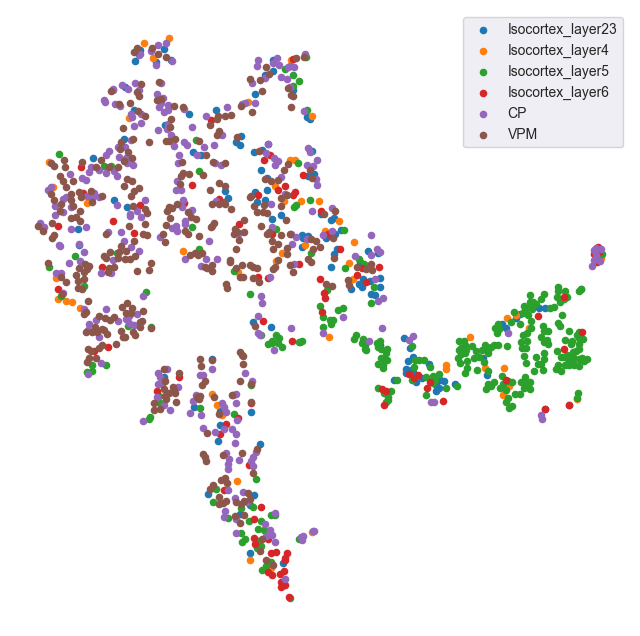

In [18]:
plot_tne(
            zzz,
            labels=ts,
            targets=['Isocortex_layer23', 'Isocortex_layer4', 'Isocortex_layer5', 'Isocortex_layer6', 'CP', "VPM" ], 
            colors=[colors[0], colors[1], colors[2], colors[3], colors[4], colors[5]]
        )